## EN3150 Assignment 02: Learning from data and related challenges and classification

### 1. Linear Regression

**1. Reason behind OLS fitted line not aligning with the majortiy of data points.** 
Ordinary Least Squares minimizes the sum of squared residuals:

$L = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$



Because the errors are squared, points with large residuals (outliers) have a disproportionately high influence on the loss.

In the plot, most data points lie along a nearly horizontal line. But the outliers have very high or very low y- values. These outliers pull the regression line towards themselves, as OLS tries to minimize the loss function. As a results of this, the OLS fitted line ends up being tilted upwards and misaligned with the majority of data, because it is trying to compromise between fitting the bulk of the points and reducing the large errors from the outliers.

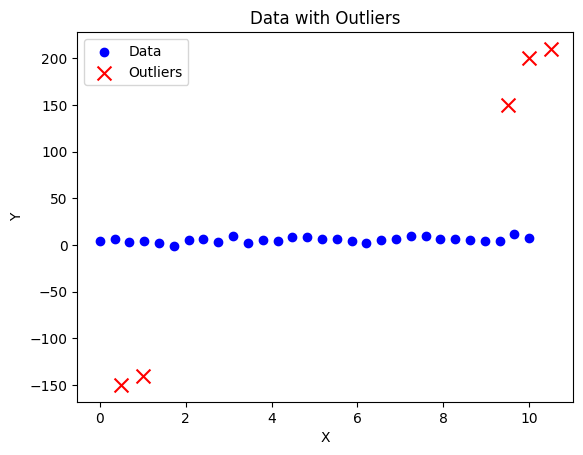

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Generate main data (blue points)
x_data = np.linspace(0, 10, 30)
y_data = 3 + 0.5 * x_data + np.random.normal(0, 2, len(x_data))  # linear trend + noise

# Add outliers (red crosses)
x_outliers = np.array([0.5, 1.0, 9.5, 10.0, 10.5])
y_outliers = np.array([-150, -140, 150, 200, 210])

# Combine them if needed
x_all = np.concatenate([x_data, x_outliers])
y_all = np.concatenate([y_data, y_outliers])

# Plot
plt.scatter(x_data, y_data, color="blue", label="Data")
plt.scatter(x_outliers, y_outliers, color="red", marker="x", s=100, label="Outliers")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Data with Outliers")
plt.show()



In [8]:
# ----------------------------
# Step 2: Define custom loss
# ----------------------------
def loss(alpha, y_i, y_ihat):
    N = len(y_i)
    return (1/N) * np.sum(((y_i - y_ihat)**2) * alpha)

In [9]:
# ----------------------------
# Step 3: Weighted Least Squares solver
# ----------------------------
def weighted_least_squares(X, y, alpha):
    W = np.diag(alpha)
    beta = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)
    return beta  # [intercept, slope]

In [10]:

# ----------------------------
# Step 5: Scheme 1 (downweight outliers)
# ----------------------------
alpha_s1 = np.ones(len(y))
alpha_s1[-len(x_outliers):] = 0.01   # outliers get very low weight
beta_s1 = weighted_least_squares(X, y, alpha_s1)

# ----------------------------
# Step 6: Scheme 2 (upweight outliers)
# ----------------------------
alpha_s2 = np.ones(len(y))
alpha_s2[-len(x_outliers):] = 5   # outliers get high weight
beta_s2 = weighted_least_squares(X, y, alpha_s2)

# ----------------------------
# Step 7: Predictions
# ----------------------------
xx = np.linspace(min(x)-1, max(x)+1, 200)
Xx = np.c_[np.ones(len(xx)), xx]

yhat_ols = Xx @ beta_ols
yhat_s1 = Xx @ beta_s1
yhat_s2 = Xx @ beta_s2

NameError: name 'x' is not defined

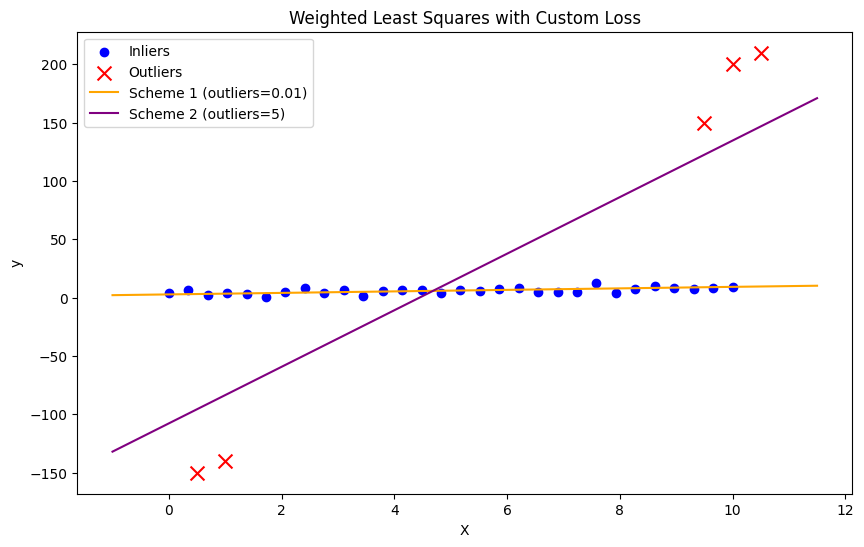

Scheme 1: coef = 0.6467375399791114 intercept = 2.8411124549058973
Scheme 2: coef = 24.237228499838558 intercept = -107.69196329288137
Loss Scheme 1: 43.73192033741543
Loss Scheme 2: 6521.947229931382


In [ ]:
# ----------------------------
# Step 8: Plot
# ----------------------------
plt.figure(figsize=(10,6))
plt.scatter(x_data, y_data, color="blue", label="Inliers")
plt.scatter(x_outliers, y_outliers, color="red", marker="x", s=100, label="Outliers")


plt.plot(xx, yhat_s1, "orange", label="Scheme 1 (outliers=0.01)")
plt.plot(xx, yhat_s2, "purple", label="Scheme 2 (outliers=5)")

plt.xlabel("X")
plt.ylabel("y")
plt.title("Weighted Least Squares with Custom Loss")
plt.legend()
plt.show()

# ----------------------------
# Step 9: Print results
# ----------------------------

print("Scheme 1: coef =", beta_s1[1], "intercept =", beta_s1[0])
print("Scheme 2: coef =", beta_s2[1], "intercept =", beta_s2[0])

# Loss values

print("Loss Scheme 1:", loss(alpha_s1, y, X @ beta_s1))
print("Loss Scheme 2:", loss(alpha_s2, y, X @ beta_s2))

**Selected scheme and justification:**   Scheme 1 will give a better fitted line than the inliers than OLS, because it reduces the influence of outliers. This is achieved by assigning very small weights to outliers minimizing their effect on the regression line, allowing the fit to be driven primarily by the inliers. 

**3.** Linear regression is unsuitable for identifying the most predictive brain regions in fMRI analysis due to its inability to handle high-dimensional data, where the number of voxels far exceeds the number of observations, leading to overfitting and unstable coefficient estimates. The strong multicollinearity among spatially correlated voxels violates the independence assumption, inflating variance and reducing reliability. Additionally, linear regression lacks built-in feature selection to highlight key regions and does not respect the grouped structure of brain regions (e.g., W1, W2, ..., WG), potentially selecting isolated voxels rather than whole regions. Alternative methods like group lasso, which enforce group sparsity and incorporate regional priors, are better suited for this task, offering improved interpretability and predictive accuracy.

**5.** Group LASSO is more appropriate for this setting compared to standard LASSO. In brain image analysis, where the goal is to identify the most predictive brain regions, the data is naturally structured into groups of voxels (e.g., regions W1, W2, ..., WG). Group LASSO accounts for this structure by applying a penalty on the L2 norm of the weight sub-vectors (∥wg∥2) for each group, encouraging the selection or exclusion of entire regions rather than individual voxels. This aligns with the biological and interpretative need to evaluate regions holistically. In contrast, standard LASSO applies an L1 penalty (∥w∥1) to individual voxel weights, leading to scattered selections across regions, which can fragment the analysis and reduce interpretability. Thus, Group LASSO better respects the grouped nature of the data and is more suitable for identifying predictive brain regions.

### 2. Logistic Regression

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

 # Load the penguins dataset
df = sns.load_dataset("penguins")
df.dropna(inplace=True)
 # Filter rows for 'Adelie' and 'Chinstrap' classes
selected_classes = ['Adelie', 'Chinstrap']
df_filtered = df[df['species'].isin(selected_classes)].copy()
 # Make a copy to avoid the warning
 # Initialize the LabelEncoder
le = LabelEncoder()
 # Encode the species column
y_encoded = le.fit_transform(df_filtered['species']) 
df_filtered['class_encoded'] = y_encoded
# Display the filtered and encoded DataFrame
print(df_filtered[['species', 'class_encoded']])
 # Split the data into features (X) and target variable (y)
y = df_filtered['class_encoded'] # Target variable
X = df_filtered.drop(['class_encoded'], axis=1)

ModuleNotFoundError: No module named 'seaborn'

**2.** Following error was encountered

ValueError                                Traceback (most recent call last)
/tmp/ipython-input-1713190823.py in <cell line: 0>()
      4  #solver to learn weights.
      5 logreg = LogisticRegression(solver='saga')
----> 6 logreg.fit(X_train, y_train)
      7  # Predict on the testing data
      8 y_pred = logreg.predict(X_test)

6 frames
/usr/local/lib/python3.12/dist-packages/pandas/core/generic.py in __array__(self, dtype, copy)
   2151     ) -> np.ndarray:
   2152         values = self._values
-> 2153         arr = np.asarray(values, dtype=dtype)
   2154         if (
   2155             astype_is_view(values.dtype, arr.dtype)

ValueError: could not convert string to float: 'Adelie

### 3.  Logistic regression First/Second-Order Methods

1.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
 # Generate synthetic data
np.random.seed(0)
centers = [[-5, 0], [5, 1.5]]
X, y = make_blobs(n_samples=2000, centers=centers, random_state=5)
transformation = [[0.5, 0.5], [-0.5, 1.5]]
X = np.dot(X, transformation)

2.

Iteration 1: Loss = 0.6715
Iteration 2: Loss = 0.6305
Iteration 3: Loss = 0.5935
Iteration 4: Loss = 0.5601
Iteration 5: Loss = 0.5298
Iteration 6: Loss = 0.5023
Iteration 7: Loss = 0.4773
Iteration 8: Loss = 0.4545
Iteration 9: Loss = 0.4337
Iteration 10: Loss = 0.4146
Iteration 11: Loss = 0.3970
Iteration 12: Loss = 0.3809
Iteration 13: Loss = 0.3660
Iteration 14: Loss = 0.3522
Iteration 15: Loss = 0.3394
Iteration 16: Loss = 0.3275
Iteration 17: Loss = 0.3164
Iteration 18: Loss = 0.3060
Iteration 19: Loss = 0.2963
Iteration 20: Loss = 0.2872


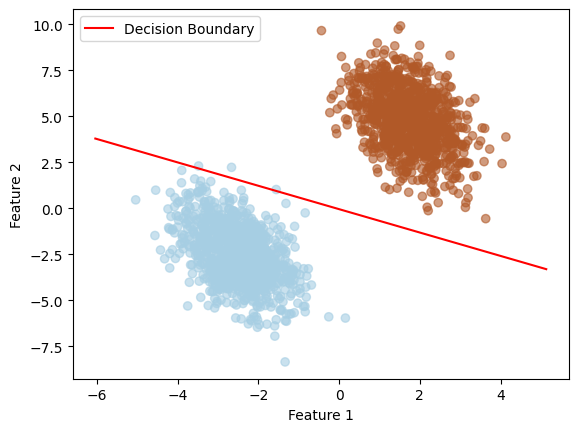

In [12]:
# Add bias term (x0 = 1)
X = np.c_[np.ones((X.shape[0], 1)), X]   # shape (2000, 3)

# Parameters
n_samples, n_features = X.shape
learning_rate = 0.01
n_iterations = 20

# Initialize weights with small random values
weights = np.random.randn(n_features) * 0.01

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Batch Gradient Descent
for i in range(n_iterations):
    # Predictions
    z = np.dot(X, weights)
    y_pred = sigmoid(z)
    
    # Compute gradient (batch)
    gradient = (1/n_samples) * np.dot(X.T, (y_pred - y))
    
    # Update weights
    weights -= learning_rate * gradient
    
    # Compute loss (log loss)
    loss = - (1/n_samples) * np.sum(y * np.log(y_pred + 1e-8) + (1-y) * np.log(1 - y_pred + 1e-8))
    
    print(f"Iteration {i+1}: Loss = {loss:.4f}")

# Final decision boundary visualization
x_values = [np.min(X[:,1]-1), np.max(X[:,1]+1)]
y_values = -(weights[0] + np.dot(weights[1], x_values)) / weights[2]

plt.scatter(X[:,1], X[:,2], c=y, cmap=plt.cm.Paired, alpha=0.6)
plt.plot(x_values, y_values, label="Decision Boundary", color="red")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

**Weight Initialization Method** 

The weights were initialized using small random values drawn from a normal distribution with mean 0 and standard deviation 0.01:

$$
w \sim \mathcal{N}(0, 0.012)
$$

**Reason for Weight Initialization Selection**

- **Breaks symmetry:** If all weights were initialized to zero, every parameter would receive the same gradient during training, preventing the model from learning meaningful patterns.

- **Prevents saturation:** Very large initial weights can push the sigmoid function into regions where gradients vanish, slowing down learning.

- **Ensures stable and efficient convergence:** Small random initialization allows weights to start close to zero but not identical, leading to faster convergence in gradient descent.


3.

 **Loss Function Used** - Binary Cross-Entropy Loss was used

$$
L(y, \hat{y}) = - \frac{1}{N} \sum_{i=1}^{N} \Big[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \Big]
$$

where:  

- \(y_i\) is the true label (0 or 1)  
- \(\hat{y}_i\) is the predicted probability for class 1  
- \(N\) is the number of samples



**Reason for Selection**

1. Suitable for binary classification: Binary cross-entropy directly measures the difference between predicted probabilities and actual class labels.

2. Smooth and differentiable: Allows efficient gradient computation for batch gradient descent.

3. Penalizes confident wrong predictions more: Helps the model adjust weights effectively during training.

4.

Iteration 1: Loss = 0.2787
Iteration 2: Loss = 0.0900
Iteration 3: Loss = 0.0338
Iteration 4: Loss = 0.0132
Iteration 5: Loss = 0.0052
Iteration 6: Loss = 0.0021
Iteration 7: Loss = 0.0009
Iteration 8: Loss = 0.0004
Iteration 9: Loss = 0.0002
Iteration 10: Loss = 0.0001
Iteration 11: Loss = 0.0000
Iteration 12: Loss = 0.0000
Iteration 13: Loss = 0.0000
Iteration 14: Loss = 0.0000
Iteration 15: Loss = 0.0000
Iteration 16: Loss = 0.0000
Iteration 17: Loss = 0.0000
Iteration 18: Loss = 0.0000
Iteration 19: Loss = 0.0000
Iteration 20: Loss = -0.0000


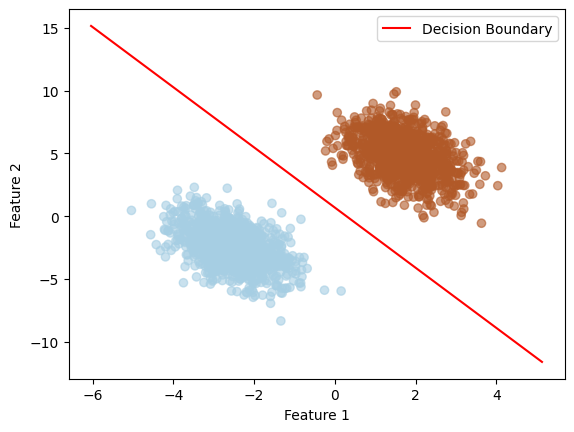

In [13]:
for i in range(n_iterations):
    z = np.dot(X, weights)
    y_pred = sigmoid(z)
    
    # Gradient
    gradient = (1/X.shape[0]) * np.dot(X.T, (y_pred - y))
    
    # Hessian
    R = np.diag(y_pred * (1 - y_pred))
    H = (1/X.shape[0]) * np.dot(np.dot(X.T, R), X)
    
    # Update weights
    weights -= np.linalg.inv(H).dot(gradient)
    
    # Compute loss (log loss)
    loss = - (1/X.shape[0]) * np.sum(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
    
    print(f"Iteration {i+1}: Loss = {loss:.4f}")

# Optional: visualize decision boundary
x_values = [np.min(X[:,1]-1), np.max(X[:,1]+1)]
y_values = -(weights[0] + weights[1]*np.array(x_values)) / weights[2]

plt.scatter(X[:,1], X[:,2], c=y, cmap=plt.cm.Paired, alpha=0.6)
plt.plot(x_values, y_values, label="Decision Boundary", color="red")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

5.

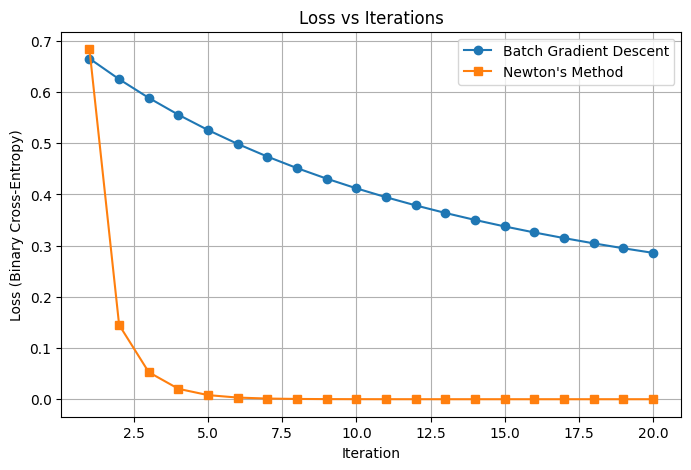

In [15]:
# -------------------------------
# Batch Gradient Descent
# -------------------------------
weights_bgd = np.random.randn(X.shape[1]) * 0.01
loss_bgd_1 = []

for i in range(n_iterations):
    y_pred = sigmoid(np.dot(X, weights_bgd))
    gradient = (1/X.shape[0]) * np.dot(X.T, (y_pred - y))
    weights_bgd -= learning_rate * gradient
    loss = - (1/X.shape[0]) * np.sum(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
    loss_bgd_1.append(loss)

# -------------------------------
# Newton's Method
# -------------------------------
weights_newton = np.random.randn(X.shape[1]) * 0.01
loss_newton = []

for i in range(n_iterations):
    y_pred = sigmoid(np.dot(X, weights_newton))
    gradient = (1/X.shape[0]) * np.dot(X.T, (y_pred - y))
    R = np.diag(y_pred * (1 - y_pred))
    H = (1/X.shape[0]) * np.dot(np.dot(X.T, R), X)
    weights_newton -= np.linalg.inv(H).dot(gradient)
    loss = - (1/X.shape[0]) * np.sum(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
    loss_newton.append(loss)

# -------------------------------
# Plot Loss vs Iterations
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, n_iterations+1), loss_bgd_1, marker='o', label='Batch Gradient Descent')
plt.plot(range(1, n_iterations+1), loss_newton, marker='s', label="Newton's Method")
plt.xlabel("Iteration")
plt.ylabel("Loss (Binary Cross-Entropy)")
plt.title("Loss vs Iterations")
plt.legend()
plt.grid(True)
plt.show()

**Comments on the resutls**

When comparing the loss curves of Batch Gradient Descent (BGD) and Newton’s Method, it is evident that Newton’s Method converges much faster than BGD. The loss for Newton’s Method drops sharply in the first few iterations, reaching near-minimum values quickly, while BGD exhibits a more gradual decrease in loss over the 20 iterations. This difference occurs because Newton’s Method uses second-order derivative information (the Hessian) to adjust the weights more precisely, whereas BGD relies solely on the first-order gradient and a fixed learning rate. Although Newton’s Method converges faster, it requires computation of the Hessian and its inverse, which can be expensive for large datasets, whereas BGD is simpler and scales better for larger problems. Overall, Newton’s Method is more efficient for smaller datasets, while BGD provides a reliable, computationally cheaper alternative.





6.

 **Approaches to Decide Number of Iterations**

#### 1. Convergence-Based Approach
- Stop iterating when the change in the loss function between consecutive iterations falls below a predefined threshold \( \epsilon \).  
- Formula:  
  $$
  \text{Stop if } |L_{t+1} - L_t| < \epsilon
  $$ 
- This ensures that iterations continue only as long as the model is still learning significantly, avoiding unnecessary computations once convergence is reached.  
- Works for both **Gradient Descent** and **Newton’s Method**, though Newton’s Method typically converges in fewer iterations.

#### 2. Maximum Iteration Limit
- Set a fixed maximum number of iterations as a safeguard.  
- For **Gradient Descent**: Usually higher (e.g., hundreds or thousands) because convergence is slower.  
- For **Newton’s Method**: Typically lower (e.g., 10–50) since convergence is faster.  
- This prevents infinite loops in case convergence criteria fail or oscillations occur, and provides control over computational cost.  



7. 

Iteration  1 - Loss: 0.690050
Iteration  2 - Loss: 0.688167
Iteration  3 - Loss: 0.686330
Iteration  4 - Loss: 0.684537
Iteration  5 - Loss: 0.682782
Iteration  6 - Loss: 0.681063
Iteration  7 - Loss: 0.679376
Iteration  8 - Loss: 0.677720
Iteration  9 - Loss: 0.676090
Iteration 10 - Loss: 0.674486
Iteration 11 - Loss: 0.672906
Iteration 12 - Loss: 0.671347
Iteration 13 - Loss: 0.669809
Iteration 14 - Loss: 0.668290
Iteration 15 - Loss: 0.666788
Iteration 16 - Loss: 0.665303
Iteration 17 - Loss: 0.663834
Iteration 18 - Loss: 0.662380
Iteration 19 - Loss: 0.660940
Iteration 20 - Loss: 0.659514


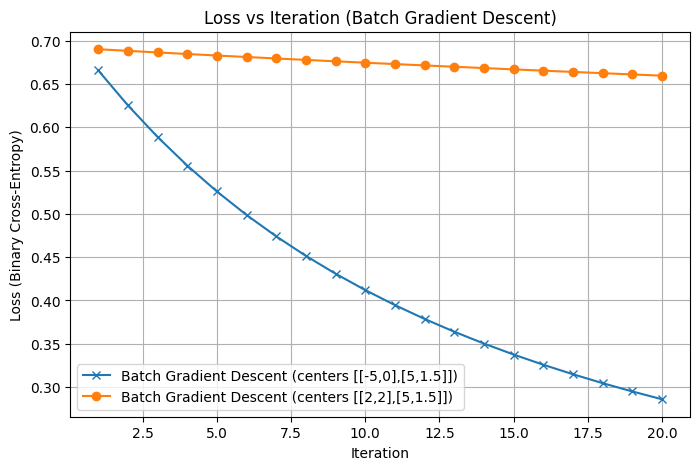

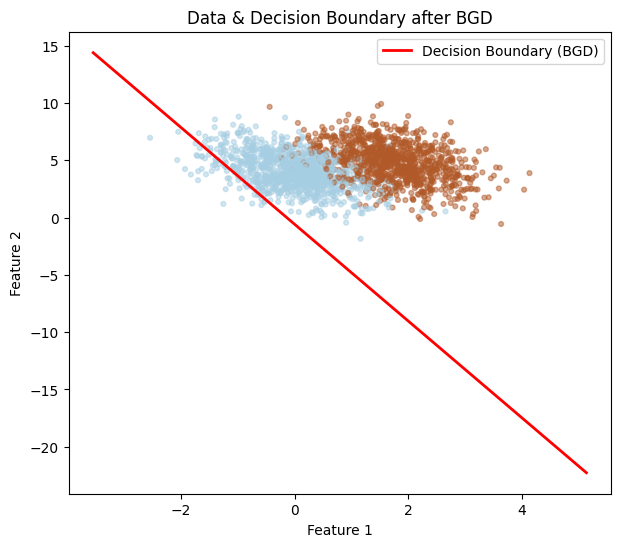

In [17]:
np.random.seed(0)
centers = [[2, 2], [5, 1.5]]            
X, y = make_blobs(n_samples=2000, centers=centers, random_state=5)
transformation = [[0.5, 0.5], [-0.5, 1.5]]
X = np.dot(X, transformation)

# Add bias term
X = np.c_[np.ones((X.shape[0], 1)), X]  # shape (2000, 3)

# Sigmoid and loss
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def binary_cross_entropy(y_true, y_prob):
    eps = 1e-12
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

# -----------------------
# Batch Gradient Descent
# -----------------------
n_iterations = 20
learning_rate = 0.01

# initialize weights small random
weights_bgd = np.random.randn(X.shape[1]) * 0.01

loss_bgd = []
for i in range(n_iterations):
    z = X.dot(weights_bgd)
    y_pred = sigmoid(z)
    gradient = (1 / X.shape[0]) * X.T.dot(y_pred - y)   # batch gradient
    weights_bgd -= learning_rate * gradient
    loss = binary_cross_entropy(y, y_pred)
    loss_bgd.append(loss)
    print(f"Iteration {i+1:2d} - Loss: {loss:.6f}")

# -----------------------
# Plot loss curve
# -----------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, n_iterations+1), loss_bgd_1, marker='x', label='Batch Gradient Descent (centers [[-5,0],[5,1.5]])')
plt.plot(range(1, n_iterations+1), loss_bgd, marker='o', label='Batch Gradient Descent (centers [[2,2],[5,1.5]])')
plt.xlabel("Iteration")
plt.ylabel("Loss (Binary Cross-Entropy)")
plt.title("Loss vs Iteration (Batch Gradient Descent)")
plt.grid(True)
plt.legend()
plt.show()


x_vals = np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200)
if np.abs(weights_bgd[2]) > 1e-8:
    y_vals = - (weights_bgd[0] + weights_bgd[1] * x_vals) / weights_bgd[2]
    plt.figure(figsize=(7,6))
    plt.scatter(X[:,1], X[:,2], c=y, cmap=plt.cm.Paired, alpha=0.5, s=12)
    plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Decision Boundary (BGD)')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Data & Decision Boundary after BGD")
    plt.legend()
    plt.show()
else:
    print("Boundary cannot be plotted (w2 approximately zero).")


**Explanation for the Convergence Behaviour** 

When the cluster centers are changed to [[2, 2], [5, 1.5]], Batch Gradient Descent still reduces the binary cross-entropy loss but the convergence behavior changes compared to the earlier, more-separated clusters. Because these new centers are closer together and occupy a similar region of the feature space (after the linear transformation), the two classes overlap more; this reduces separability and makes the optimization landscape flatter and noisier. As a result, the loss decreases more slowly and may settle at a higher final value within the same number of iterations. The learning rate also affects this behavior: if it is too large the loss may oscillate, and if it is too small convergence will be very slow. In practice, for this configuration you may observe a gentler slope in the loss curve (slower progress per iteration) and possibly a higher plateau, indicating that the model needs more iterations, regularization or feature scaling (standardization) to reach similar performance to the well-separated case. Newton’s method (if applied) would likely still converge faster in iterations because it uses curvature information, but the final achievable loss is bounded by the data’s inherent overlap.